In [23]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerTuple
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from scipy.stats import linregress, gmean, gstd

plt.style.use('style.mpl')

In [2]:
# Large kcat dataset from Li et al. 2022 includes SMILES strings for substrates
kcat_data = pd.read_json('../data/enzymes/Li2022_DLKat_kcats.json')

In [4]:
def count_C_atoms(smiles):
    m = Chem.MolFromSmiles(smiles)
    atomic_count = defaultdict(lambda : 0)
    for atom in m.GetAtoms():
        atomic_count[atom.GetAtomicNum()] += 1

    return atomic_count[6]

get_formula = lambda x: CalcMolFormula(Chem.MolFromSmiles(x))

formulae = kcat_data.Smiles.map(get_formula)
C_counts = kcat_data.Smiles.map(count_C_atoms)
kcat_data['substrate_formula'] = formulae
kcat_data['substrate_C_count'] = C_counts
kcat_data['kcat_C_per_s'] = kcat_data.substrate_C_count * kcat_data.Value
kcat_data.to_csv('../data/enzymes/Li2022_DLKat_kcats_C_counts.csv', index=False)

[14:44:13] WARNING: not removing hydrogen atom without neighbors
[14:44:13] WARNING: not removing hydrogen atom without neighbors
[14:44:16] WARNING: not removing hydrogen atom without neighbors
[14:44:16] WARNING: not removing hydrogen atom without neighbors


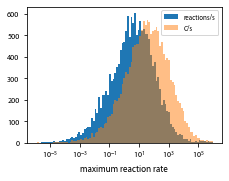

In [21]:
plt.figure(figsize=(3.5, 2.5))
plt.xscale('log')

mask = np.logical_and(kcat_data.Value > 0, kcat_data.kcat_C_per_s > 0)
masked = kcat_data[mask]
bins = np.logspace(-6, 6, 100)
plt.hist(masked.Value, label='reactions/s', bins=bins)
plt.hist(masked.kcat_C_per_s, label='C/s', bins=bins, alpha=0.5)
plt.xlabel('maximum reaction rate')
plt.legend()
plt.show()

In [25]:
# Calculate the average difference between the two notions of kcat
gmean_kcat = gmean(masked.Value)
gmean_kcat_c_per_s = gmean(masked.kcat_C_per_s)
gstdev_kcat = gstd(masked.Value)
gstdev_kcat_c_per_s = gstd(masked.kcat_C_per_s)

print(f'geometric mean kcat: {gmean_kcat:.2e} reactions/s +/- {gstdev_kcat:.2g} fold')
print(f'geometric mean kcat_C: {gmean_kcat_c_per_s:.2e} C/s +/- {gstdev_kcat_c_per_s:.2g} fold')
print(f'ratio of means: {gmean_kcat_c_per_s / gmean_kcat:.2e}')

geometric mean kcat: 3.51e+00 reactions/s +/- 31 fold
geometric mean kcat_C: 3.28e+01 C/s +/- 31 fold
ratio of means: 9.36e+00


In [43]:
enz_data = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='1. KineticTable')
enz_data.columns = 'EC1,EC2,EC3,EC4,compound_ID,reaction_ID,direction,organism_ID,publication_ID,T,pH,KM_uM,kcat_s'.split(',')
enz_data.head()

modules = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='6. Metabolic Modules')
modules.columns = 'reaction_ID,module_ID'.split(',')
modules = modules.set_index('reaction_ID')

module_groups = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='module_groups')
module_groups.columns = 'module_ID,module_name,module_type'.split(',')
module_groups = module_groups.set_index('module_ID')

In [51]:
module_groups.module_type.value_counts()

Intermediate                                          152
Primary - amino acids, fatty acids and nucleotides     60
Secondary                                              46
x                                                      28
Primary - Carbohydrate & Energy Metabolism             25
Name: module_type, dtype: int64

In [44]:
# Join in module information. Default join is 'left' i.e. keep all rows in enz_data.
enz_data = enz_data.join(modules, on='reaction_ID').join(module_groups, on='module_ID')
enz_data.to_csv('../data/enzymes/BarEven2011_compact_kinetics.csv', index=False)

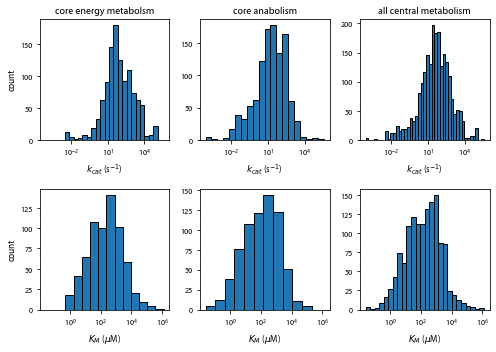

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7, 5), sharex='row')

notnull = enz_data.kcat_s.notnull()
mask_primary_energy = np.logical_and(
    notnull, enz_data.module_type == 'Primary - Carbohydrate & Energy Metabolism')
mask_primary_biosyn = np.logical_and(
    notnull, enz_data.module_type == 'Primary - amino acids, fatty acids and nucleotides')
mask_primary_all = np.logical_or(mask_primary_energy, mask_primary_biosyn)
mask_secondary = np.logical_and(
    notnull, enz_data.module_type == 'Secondary')

masks = [mask_primary_energy, mask_primary_biosyn, mask_primary_all]
names = ['core energy metabolsm', 'core anabolism', 'all central metabolism']
for i, (mask, name) in enumerate(zip(masks, names)):
    plt.sca(axs[0, i])
    plt.xscale('log')
    masked = enz_data[mask]
    n_vals = masked.kcat_s.notnull().sum()
    bins = np.logspace(
        np.log10(masked.kcat_s.min()),
        np.log10(masked.kcat_s.max()),
        int(n_vals/50))
    plt.hist(masked.kcat_s, label=name, bins=bins, edgecolor='k')
    plt.title(name)
    plt.xlabel('$k_{cat}$ (s$^{-1}$)')

for i, (mask, name) in enumerate(zip(masks, names)):
    plt.sca(axs[1, i])
    plt.xscale('log')
    masked = enz_data[mask]
    n_vals = masked.KM_uM.notnull().sum()
    bins = np.logspace(
        np.log10(masked.KM_uM.min()),
        np.log10(masked.KM_uM.max()),
        int(n_vals/50))
    plt.hist(masked.KM_uM, label=name, bins=bins, edgecolor='k')
    plt.xlabel('$K_{M}$ ($\mu$M)')

for i in range(2):
    plt.sca(axs[i, 0])
    plt.ylabel('count')

plt.tight_layout()
plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_42652/3864715398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
/opt/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#000000') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


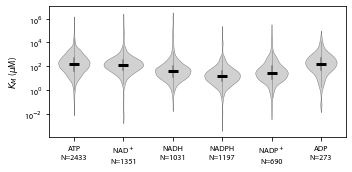

In [22]:
cpds = {
    2: 'ATP',
    8: 'ADP',
    3: 'NAD$^+$',
    4: 'NADH',
    6: 'NADP$^+$',
    5: 'NADPH',
}
cpd_order = sorted(cpds.keys())
sub_df = enz_data[enz_data.compound_ID.isin(cpds.keys())]
sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
counts = sub_df.groupby('compound_ID').agg({'KM_uM':'count'}).values.T[0].tolist()
medians = sub_df.groupby('compound_ID').agg({'KM_uM':'median', 'log_KM_uM':'median'})

@FuncFormatter
def my_formatter(x, pos):
     return r"10$^{{{0:0.0f}}}$".format(x)

plt.figure(figsize=(5,2.5))
greys = sns.color_palette('Greys', 6)
sns.violinplot(data=sub_df, x='compound_ID', y='log_KM_uM', marker='d', s=4, order=cpd_order, color=greys[1], edgecolor='k', linewidth=0.5, jitter=0.3)
sns.stripplot(data=medians, x=medians.index, y='log_KM_uM', marker='_', s=10, order=cpd_order, color='k', linewidth=3, jitter=0)

xs = np.arange(6)
labels = [cpds[i] for i in cpd_order]
labels = ['{0}\nN={1}'.format(l, n) for l,n in zip(labels, counts)]
plt.xticks(xs, labels)
plt.xlabel('')
plt.ylabel('$K_M$ ($\mu$M)')
plt.gca().yaxis.set_major_formatter(my_formatter)


plt.tight_layout()
plt.savefig('../output/enzyme_KMs.png', dpi=600, facecolor='w')
plt.show()

2980.094925360276

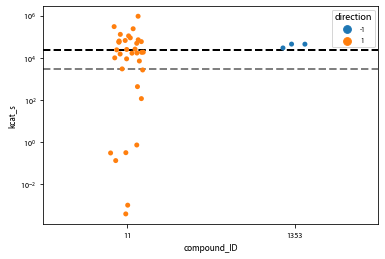

In [9]:
CA_mask1 = np.logical_and(enz_data.EC1 == 4, enz_data.EC2 == 2)
CA_mask2 = np.logical_and(enz_data.EC3 == 1, enz_data.EC4 == 1)
CA_mask = np.logical_and(CA_mask1, CA_mask2)
CAs = enz_data[CA_mask]

plt.figure()
plt.yscale('log')
sns.stripplot(data=CAs, y='kcat_s', x='compound_ID', hue='direction')
plt.axhline(CAs.kcat_s.median(), color='k', ls='--')
plt.axhline(gmean(CAs[CAs.kcat_s.notnull()].kcat_s), color='grey', ls='--')

CAs.kcat_s.median()
gmean(CAs[CAs.kcat_s.notnull()].kcat_s)

In [10]:
davidi_df = pd.read_excel('../data/enzymes/Davidi2018.xlsx')

/opt/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
